In [85]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [86]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [87]:
data_dir = './datasets'

# Load the dataset WITHOUT transforms first
# We will apply specific transforms to train/val/test splits later
full_dataset = ImageFolder(root=data_dir, transform=None)

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [88]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [89]:
# Split the dataset into train, test, and validation sets using STRATIFIED split
# This ensures that each set has the same percentage of each class
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

# Get the targets (labels) for stratification
targets = full_dataset.targets# Get the targets (labels) for stratification


# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Get labels for the temp set to stratify the second split
temp_targets = [targets[i] for i in temp_idx]

# Second split: Val (50% of Temp -> 10% total) vs Test (50% of Temp -> 10% total)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    shuffle=True,
    stratify=temp_targets,
    random_state=42
)

# Create the subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1428
Val size: 178
Test size: 179


In [90]:
# Helper class to apply transforms to subsets
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# LIGHT augmentations - avoid over-regularization that makes training artificially harder
train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.2),              # Light rotation
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02, p=0.2),  # Light color
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Same as val
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))

# Apply transforms using the wrapper class
train_dataset = ApplyTransform(train_dataset, transform=train_transform)
val_dataset = ApplyTransform(val_dataset, transform=val_transform)
test_dataset = ApplyTransform(test_dataset, transform=val_transform)


In [91]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)  # Smaller batch for better generalization
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [92]:
# Squeeze-and-Excitation (SE) Attention Block
class SEBlock(nn.Module):
    """Squeeze-and-Excitation attention block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def make_all_skips_learnable(resnet):
    """
    For every BasicBlock in torchvision ResNet, ensure the skip path is a learned linear map:
    identity(x) becomes downsample(x) = 1x1 conv + BN, even when shapes match.
    """
    for layer_name in ["layer1", "layer2", "layer3", "layer4"]:
        layer = getattr(resnet, layer_name)
        for block in layer:
            if block.downsample is None:
                in_ch = block.conv1.in_channels
                out_ch = block.conv2.out_channels
                stride = block.conv1.stride[0]

                conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)
                bn = nn.BatchNorm2d(out_ch)

                # Initialize close to identity when possible (Dirac initialization)
                if in_ch == out_ch and stride == 1:
                    nn.init.dirac_(conv.weight)
                nn.init.ones_(bn.weight)
                nn.init.zeros_(bn.bias)

                block.downsample = nn.Sequential(conv, bn)
    return resnet


# Mixup augmentation for training
def mixup_data(x, y, alpha=0.4):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class CustomeResnet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomeResnet, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Make ALL skip connections learnable (Deep_Project approach)
        self.model = make_all_skips_learnable(self.model)
        
        # SE attention on later layers only
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)
        
        # Simple classification head
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),  # Added BatchNorm for stability
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        # Stem
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        # Layer 1 & 2 - with learnable skips inside BasicBlocks
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        
        # Layer 3 with SE attention (applied after the layer)
        x = self.model.layer3(x)
        x = self.se3(x)
        
        # Layer 4 with SE attention
        x = self.model.layer4(x)
        x = self.se4(x)
        
        # Classification head
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        
        return x


model = CustomeResnet(num_classes=num_classes, dropout_rate=0.15)  # Reduced from 0.3 to avoid over-regularization
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} total parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("Model: Learnable skip connections + SE attention, dropout=0.15")

/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model created with 11,575,365 total parameters
Trainable parameters: 11,575,365
Model: Learnable skip connections + SE attention, dropout=0.15


In [93]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Get the targets (labels) for stratification

# Extract labels from the train dataset indices
# Access .subset.indices because train_dataset is now an ApplyTransform wrapper
train_labels = [full_dataset.targets[i] for i in train_dataset.subset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.6320, 0.8160, 1.0737, 0.7496, 1.1156])


In [94]:
# Gradual Unfreezing Strategy
# Phase 1: Train only new layers (FC, SE, downsample projections)
# Phase 2: Unfreeze layer3 + layer4

def freeze_all_backbone(model):
    """Freeze all backbone parameters"""
    for param in model.model.parameters():
        param.requires_grad = False

def unfreeze_new_layers(model):
    """Unfreeze FC, SE attention, and learnable skip connections (downsample)"""
    # Unfreeze FC head
    for param in model.model.fc.parameters():
        param.requires_grad = True
    
    # Unfreeze SE attention blocks
    for param in model.se3.parameters():
        param.requires_grad = True
    for param in model.se4.parameters():
        param.requires_grad = True
    
    # Unfreeze all downsample (learnable skip) projections
    for name, param in model.model.named_parameters():
        if "downsample" in name:
            param.requires_grad = True

def unfreeze_layer(model, layer_name):
    """Unfreeze a specific layer"""
    layer = getattr(model.model, layer_name)
    for param in layer.parameters():
        param.requires_grad = True

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initial setup: Freeze backbone, unfreeze new layers
freeze_all_backbone(model)
unfreeze_new_layers(model)
print(f"Phase 1 - Trainable params (FC + SE + downsample): {count_trainable_params(model):,}")

Phase 1 - Trainable params (FC + SE + downsample): 572,677


In [95]:
# Define optimizer with differential learning rates

def get_optimizer(model, base_lr=0.001):
    """Create optimizer with differential learning rates"""
    # Collect downsample parameters separately
    downsample_params = []
    for name, param in model.model.named_parameters():
        if "downsample" in name and param.requires_grad:
            downsample_params.append(param)
    
    param_groups = [
        # New layers - highest learning rate
        {'params': model.model.fc.parameters(), 'lr': base_lr, 'weight_decay': 1e-3},
        {'params': model.se3.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': model.se4.parameters(), 'lr': base_lr, 'weight_decay': 1e-4},
        {'params': downsample_params, 'lr': base_lr, 'weight_decay': 1e-4},
        # Backbone layers (excluding downsample which is already added)
        {'params': [p for n, p in model.model.layer4.named_parameters() if "downsample" not in n], 
         'lr': base_lr / 2.5, 'weight_decay': 1e-4},
        {'params': [p for n, p in model.model.layer3.named_parameters() if "downsample" not in n], 
         'lr': base_lr / 5, 'weight_decay': 1e-4},
        {'params': [p for n, p in model.model.layer2.named_parameters() if "downsample" not in n], 
         'lr': base_lr / 10, 'weight_decay': 1e-4},
        {'params': [p for n, p in model.model.layer1.named_parameters() if "downsample" not in n], 
         'lr': base_lr / 10, 'weight_decay': 1e-4},
        {'params': model.model.conv1.parameters(), 'lr': base_lr / 20, 'weight_decay': 1e-4},
        {'params': model.model.bn1.parameters(), 'lr': base_lr / 20, 'weight_decay': 0},
    ]
    return optim.AdamW(param_groups)

# Loss function with reduced label smoothing for stable training
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

print("Optimizer configured with learnable skip connections + SE layers")
print("Using CrossEntropyLoss with label_smoothing=0.05")

Optimizer configured with learnable skip connections + SE layers
Using CrossEntropyLoss with label_smoothing=0.05


In [96]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)


Using device: cpu


In [97]:
# Check if CUDA is properly configured
try:
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

# ========== TRAINING WITH REDUCED REGULARIZATION ==========
# Fix: Reduce over-regularization that makes train loss artificially high
total_epochs = 35
epochs_per_phase = [15, 10, 10]  # 3 phases

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_val_loss = float('inf')
current_epoch = 0
patience_counter = 0
early_stop_patience = 6

# MINIMAL regularization for stable training
USE_MIXUP = False       # Disabled - causes training instability
MIXUP_ALPHA = 0.1       
MIXUP_PROB = 0.0        # Disabled
L1_LAMBDA = 0           # Disabled - causes train/val gap

def l1_regularization(model):
    """Calculate L1 regularization penalty"""
    l1_penalty = 0.0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.sum(torch.abs(param))
    return l1_penalty

def get_optimizer_with_proper_lr(model, head_lr=1e-4, backbone_lr=1e-5):
    """Create optimizer with proper LR: Head=1e-4, Backbone=1e-5 or lower"""
    # Collect downsample parameters
    downsample_params = []
    for name, param in model.model.named_parameters():
        if "downsample" in name and param.requires_grad:
            downsample_params.append(param)
    
    param_groups = [
        # HEAD layers - higher LR
        {'params': model.model.fc.parameters(), 'lr': head_lr, 'weight_decay': 5e-4},  # Reduced weight decay
        {'params': model.se3.parameters(), 'lr': head_lr, 'weight_decay': 5e-5},
        {'params': model.se4.parameters(), 'lr': head_lr, 'weight_decay': 5e-5},
        {'params': downsample_params, 'lr': head_lr, 'weight_decay': 5e-5},
        
        # BACKBONE layers - lower LR
        {'params': [p for n, p in model.model.layer4.named_parameters() if "downsample" not in n], 
         'lr': backbone_lr, 'weight_decay': 5e-5},
        {'params': [p for n, p in model.model.layer3.named_parameters() if "downsample" not in n], 
         'lr': backbone_lr / 2, 'weight_decay': 5e-5},
        {'params': [p for n, p in model.model.layer2.named_parameters() if "downsample" not in n], 
         'lr': backbone_lr / 5, 'weight_decay': 5e-5},
        {'params': [p for n, p in model.model.layer1.named_parameters() if "downsample" not in n], 
         'lr': backbone_lr / 5, 'weight_decay': 5e-5},
        {'params': model.model.conv1.parameters(), 'lr': backbone_lr / 10, 'weight_decay': 5e-5},
        {'params': model.model.bn1.parameters(), 'lr': backbone_lr / 10, 'weight_decay': 0},
    ]
    return optim.AdamW(param_groups)

def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, 
                    use_mixup=False, alpha=0.1, l1_lambda=0, mixup_prob=0.0):
    """Clean training without excessive regularization for stable convergence"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Standard forward pass (mixup disabled for stability)
        if use_mixup and mixup_prob > 0 and np.random.random() < mixup_prob:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Optional L1 (disabled by default for cleaner gradients)
        if l1_lambda > 0:
            l1_penalty = l1_regularization(model)
            loss = loss + l1_lambda * l1_penalty
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(train_loader.dataset), 100 * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return val_loss / len(val_loader.dataset), 100 * correct / total

def run_phase(phase_name, model, epochs, head_lr, backbone_lr, device, use_mixup=True, 
              mixup_alpha=0.1, mixup_prob=0.3, l1_lambda=L1_LAMBDA, warmup_pct=0.3):
    """Run a training phase with reduced regularization"""
    global current_epoch, best_val_accuracy, best_val_loss, patience_counter
    
    print(f"\n{'='*60}")
    print(f"{phase_name}")
    print(f"{'='*60}")
    print(f"Trainable params: {count_trainable_params(model):,}")
    print(f"Head LR: {head_lr}, Backbone LR: {backbone_lr}")
    print(f"Mixup: alpha={mixup_alpha}, prob={mixup_prob}")
    
    optimizer = get_optimizer_with_proper_lr(model, head_lr=head_lr, backbone_lr=backbone_lr)
    num_param_groups = len(optimizer.param_groups)
    
    # Build max_lr list for OneCycleLR
    backbone_factors = [1, 0.5, 0.2, 0.2, 0.1, 0.1]
    max_lrs = [head_lr] * 4 + [backbone_lr * f for f in backbone_factors[:num_param_groups - 4]]
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lrs,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=warmup_pct,
        anneal_strategy='cos',
        div_factor=10,
        final_div_factor=100
    )
    
    for epoch in range(epochs):
        current_epoch += 1
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device, 
            use_mixup=use_mixup, alpha=mixup_alpha, l1_lambda=l1_lambda, mixup_prob=mixup_prob
        )
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        overfit_gap = train_acc - val_acc
        head_current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {current_epoch}/{total_epochs} | '
              f'Train: {train_loss:.4f}/{train_acc:.2f}% | '
              f'Val: {val_loss:.4f}/{val_acc:.2f}% | '
              f'Gap: {overfit_gap:.1f}% | LR: {head_current_lr:.2e}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model1.pth')
            print('  ✓ Best model saved!')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience:
            print(f"  ⚠ Early stopping triggered after {patience_counter} epochs without improvement")
            return True
    
    return False

# ========== PHASE 1: Train new layers only ==========
freeze_all_backbone(model)
unfreeze_new_layers(model)
early_stop = run_phase(
    "PHASE 1: Training FC + SE + downsample (backbone frozen)", 
    model, epochs_per_phase[0], 
    head_lr=3e-4,           # Reduced from 1e-3 for stability
    backbone_lr=0,
    device=device,
    mixup_alpha=0.0,
    mixup_prob=0.0,         # No mixup
    warmup_pct=0.3          # Longer warmup
)

if not early_stop:
    # ========== PHASE 2: Unfreeze layer4 ==========
    unfreeze_layer(model, 'layer4')
    patience_counter = 0
    
    early_stop = run_phase(
        "PHASE 2: Fine-tuning layer4", 
        model, epochs_per_phase[1], 
        head_lr=3e-5,           # Conservative LR
        backbone_lr=3e-6,       # Very low backbone LR
        device=device,
        mixup_alpha=0.0,
        mixup_prob=0.0,
        l1_lambda=0,            # No L1
        warmup_pct=0.4          # Longer warmup for unfreezing
    )

if not early_stop:
    # ========== PHASE 3: Unfreeze layer3 ==========
    unfreeze_layer(model, 'layer3')
    patience_counter = 0
    
    run_phase(
        "PHASE 3: Fine-tuning layer3 + layer4", 
        model, epochs_per_phase[2], 
        head_lr=3e-5,           # Very conservative
        backbone_lr=3e-6,       # Minimal backbone adjustment
        device=device,
        mixup_alpha=0.0,
        mixup_prob=0.0,
        l1_lambda=0,
        warmup_pct=0.4
    )

print("\n" + "=" * 60)
print(f"Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
print("=" * 60)

CUDA test passed, using device: cpu

PHASE 1: Training FC + SE + downsample (backbone frozen)
Trainable params: 572,677
Head LR: 0.0003, Backbone LR: 0
Mixup: alpha=0.0, prob=0.0


/home/mohammad-boom/uniWork/Campus-Classificaton/.venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/35 | Train: 1.6517/27.52% | Val: 1.4382/44.94% | Gap: -17.4% | LR: 6.19e-05
  ✓ Best model saved!
Epoch 2/35 | Train: 1.1206/62.11% | Val: 0.8516/75.84% | Gap: -13.7% | LR: 1.42e-04
  ✓ Best model saved!
Epoch 3/35 | Train: 0.6853/81.44% | Val: 0.6427/84.83% | Gap: -3.4% | LR: 2.34e-04
  ✓ Best model saved!
Epoch 4/35 | Train: 0.4635/91.53% | Val: 0.4378/93.26% | Gap: -1.7% | LR: 2.92e-04
  ✓ Best model saved!
Epoch 5/35 | Train: 0.4150/94.05% | Val: 0.4461/93.26% | Gap: 0.8% | LR: 2.98e-04
Epoch 6/35 | Train: 0.3603/96.85% | Val: 0.4450/93.26% | Gap: 3.6% | LR: 2.85e-04
Epoch 7/35 | Train: 0.3284/98.11% | Val: 0.4035/93.82% | Gap: 4.3% | LR: 2.59e-04
  ✓ Best model saved!
Epoch 8/35 | Train: 0.3144/98.67% | Val: 0.4195/93.26% | Gap: 5.4% | LR: 2.24e-04
Epoch 9/35 | Train: 0.3077/99.16% | Val: 0.4084/94.94% | Gap: 4.2% | LR: 1.83e-04
Epoch 10/35 | Train: 0.3014/99.02% | Val: 0.3983/93.82% | Gap: 5.2% | LR: 1.38e-04
  ✓ Best model saved!
Epoch 11/35 | Train: 0.2924/99.44% | Val:

In [98]:
from sklearn.metrics import confusion_matrix, classification_report

# measure test accuracy
model.load_state_dict(torch.load('best_model1.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 96.09%


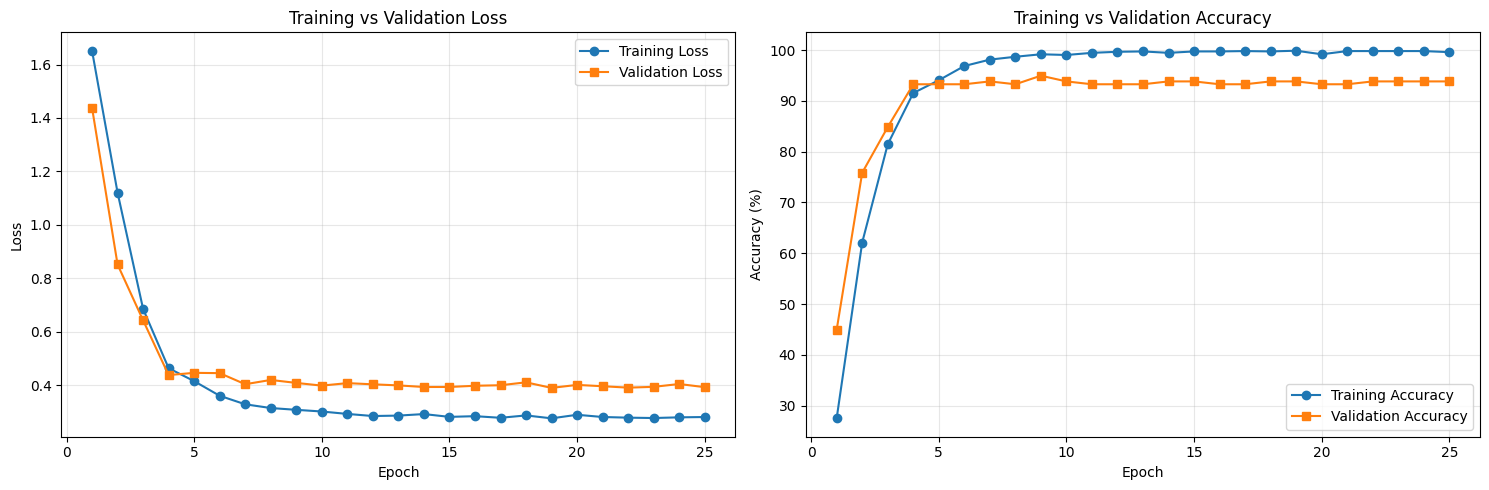

In [99]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, label="Training Loss", marker='o')
ax1.plot(epochs, val_losses, label="Validation Loss", marker='s')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [100]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')                          
print(cm)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[22  0  0  0  0]
 [ 0 43  1  0  0]
 [ 0  0 33  0  0]
 [ 1  1  2 43  1]
 [ 1  0  0  0 31]]
Classification Report:
              precision    recall  f1-score   support

         Lab       0.92      1.00      0.96        22
        Tree       0.98      0.98      0.98        44
    building       0.92      1.00      0.96        33
         car       1.00      0.90      0.95        48
      person       0.97      0.97      0.97        32

    accuracy                           0.96       179
   macro avg       0.96      0.97      0.96       179
weighted avg       0.96      0.96      0.96       179

